In [1]:
#%matplotlib inline
#%config InlineBackend.figure_format = 'retina'

# **Filtrado de imágenes**

## Teoría del filtrado de imágenes

El filtrado es una de las operaciones de imagen más básicas y comunes en el procesamiento de imágenes.

Se puede filtrar una imagen para eliminar el ruido o para mejorar sus características; la imagen filtrada puede ser el resultado deseado o sólo un paso de preprocesamiento.

En cualquier caso, el filtrado es un tema importante que hay que entender.

### Filtrado local

In [1]:
import matplotlib.pyplot as plt;
import numpy as np;

plt.rcParams['image.cmap'] = 'gray';

Por "local" en el filtrado local queremos decir simplemente que un píxel se ajusta por los valores de algún conjunto de píxels circundantes (su vecindario). Estos elementos circundantes se identifican o ponderan en función de una "huella", "elemento estructural" o "núcleo" (**kernel**).

Vamos a verlo en 1 dimensión para empezar.

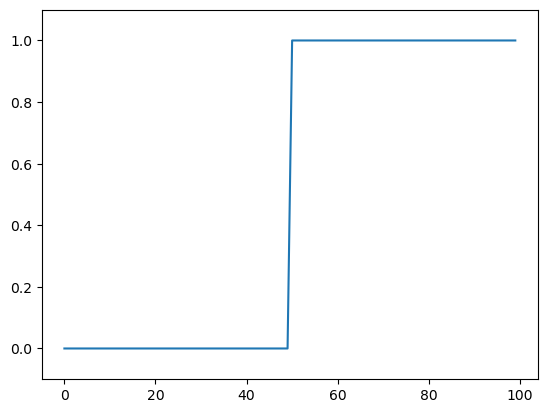

In [2]:
# generamos una señal en 1 dimensión.

step_signal = np.zeros(100);
step_signal[50:] = 1;

fig, ax = plt.subplots();
ax.plot(step_signal);
ax.margins(y=0.1);

Vamos a añadirle algún ruído a la señal generada en la celda anterior

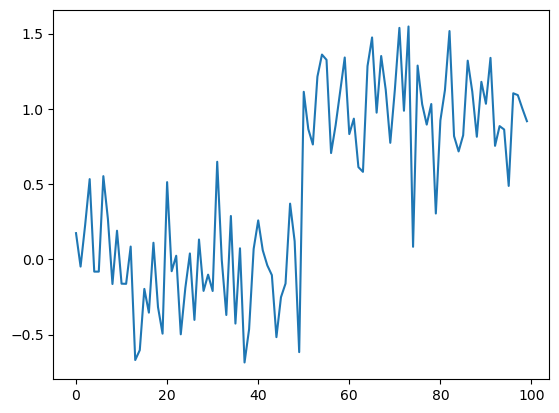

In [3]:
np.random.seed(42);

noisy_signal = (step_signal + np.random.normal(0, 0.35, step_signal.shape));

fig, ax = plt.subplots()
ax.plot(noisy_signal);

La forma más sencilla de recuperar algo que se parezca un poco a la señal original es tomar la media entre píxeles vecinos:




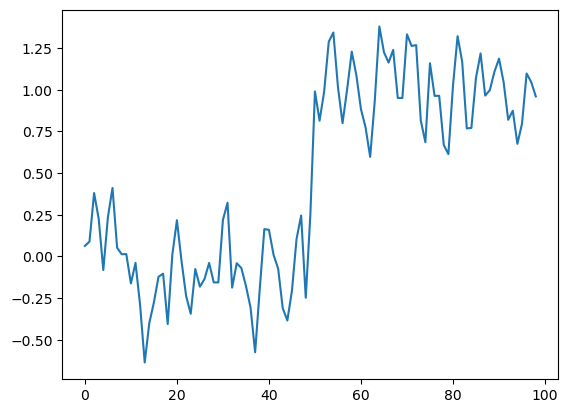

In [4]:
smooth_signal = (noisy_signal[:-1] + noisy_signal[1:]) / 2.0; # media de los vecinos

fig, ax = plt.subplots();
ax.plot(smooth_signal);

¿Y si lo hacemos con los tres tres píxeles vecinos?

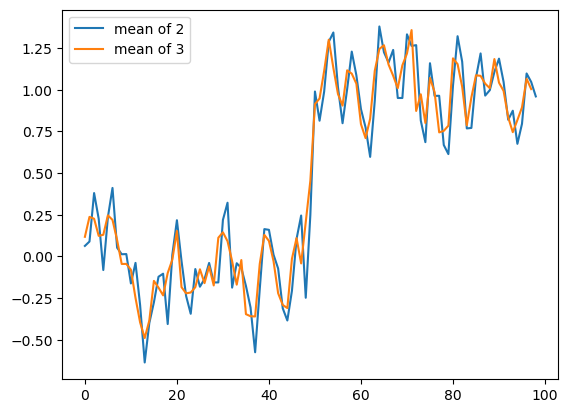

In [5]:
smooth_signal3 = (noisy_signal[:-2] + noisy_signal[1:-1] + noisy_signal[2:]) / 3; 

fig, ax = plt.subplots();
ax.plot(smooth_signal, label='mean of 2');
ax.plot(smooth_signal3, label='mean of 3');
ax.legend(loc='upper left');

Para las medias de más puntos, la expresión se vuelve más peliaguda. **Y hay que preocuparse más por lo que ocurre en los márgenes**. ¿Hay una forma mejor?

Resulta que la hay. Este concepto, los promedios del vecino más cercano (nearest-neighbor averages), puede expresarse como una *convolución* con un *núcleo de promediación*. Obsérvese que la operación que hicimos con *smooth_signal3* puede expresarse como sigue:

* Crear un array de salida llamado *smooth_signal3*, de la misma longitud que *noisy_signal*.
* En cada elemento de *smooth_signal3* comenzando en el punto 1, y terminando en el punto -2, calcular la suma de: 1/3 del elemento a la izquierda en *noisy_signal*, 1/3 del elemento en la misma posición, y 1/3 del elemento a la derecha.
* Descartar los elementos más a la izquierda y a la derecha.

Esto se llama una *convolución* entre la imagen de entrada y el array [1/3, 1/3, 1/3].

¿smooth_signal3 y smooth_signal3p son iguales? True


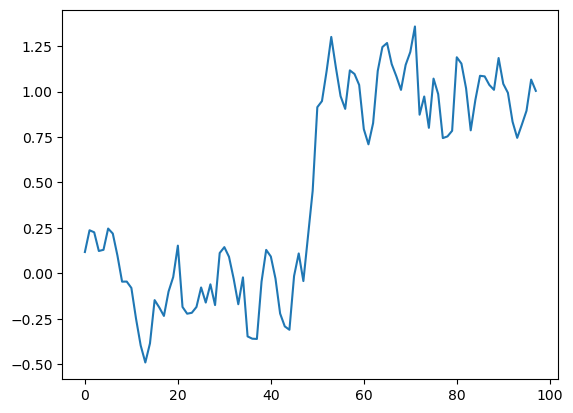

In [7]:
# Vamos a hacer lo mismo que antes, pero usando un kernel de convolución
# Pixels vecinos multiplicados por 1/3 y sumados
mean_kernel3 = np.full((3,), 1/3); # creo un vector que contiene 1/3 de los elementos

smooth_signal3p = np.convolve(noisy_signal, mean_kernel3, mode='valid'); # le aplicamos un convolución a una imagen

fig, ax = plt.subplots();
ax.plot(smooth_signal3p);

print('¿smooth_signal3 y smooth_signal3p son iguales?', np.allclose(smooth_signal3, smooth_signal3p))

In [8]:
def convolve_demo(signal, kernel):
    ksize = len(kernel)
    convolved = np.correlate(signal, kernel)
    def filter_step(i):
        fig, ax = plt.subplots()
        ax.plot(signal, label='Señal')
        ax.plot(convolved[:i+1], label='Convolución')
        ax.legend()
        ax.scatter(np.arange(i, i+ksize), signal[i : i+ksize])
        ax.scatter(i, convolved[i])
    return filter_step

from ipywidgets import interact, widgets

i_slider = widgets.IntSlider(min=0, max=len(noisy_signal) - 3, value=0)

interact(convolve_demo(noisy_signal, mean_kernel3), i=i_slider);

interactive(children=(IntSlider(value=0, description='i', max=97), Output()), _dom_classes=('widget-interact',…

La ventaja de la convolución es que es tan fácil sacar la media de 11 puntos como de 3:

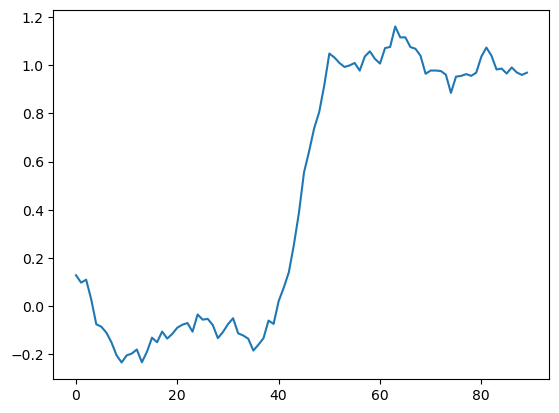

In [9]:
n=11;

mean_kernel11 = np.full((n,), 1/n);

smooth_signal11 = np.convolve(noisy_signal, mean_kernel11, mode='valid');

fig, ax = plt.subplots();
ax.plot(smooth_signal11);

In [10]:
i_slider = widgets.IntSlider(min=0, max=len(noisy_signal) - 11, value=0)

interact(convolve_demo(noisy_signal, mean_kernel11), i=i_slider);

interactive(children=(IntSlider(value=0, description='i', max=89), Output()), _dom_classes=('widget-interact',…

Por supuesto, para tomar la media de 11 valores, tenemos que alejarnos cada vez más de los bordes, y esto empieza a notarse. Puedes usar *mode='same'* para rellenar los bordes del array y calcular un resultado del mismo tamaño que la entrada:

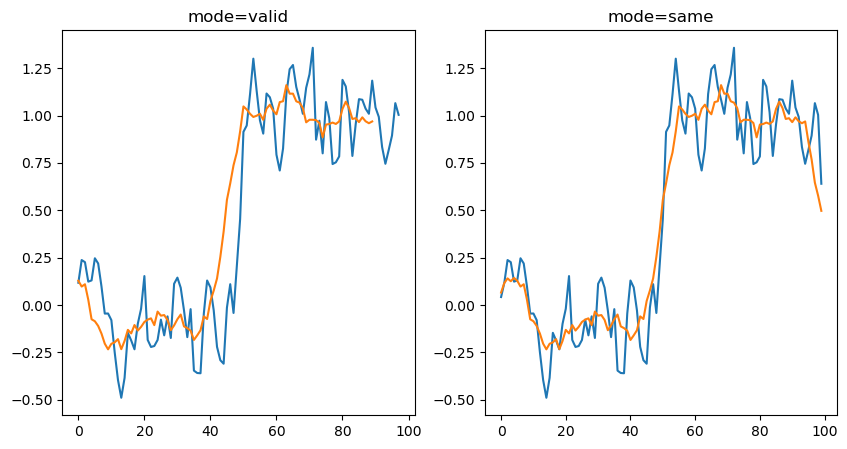

In [11]:
smooth_signal3same  = np.convolve(noisy_signal, mean_kernel3,  mode='same');
smooth_signal11same = np.convolve(noisy_signal, mean_kernel11, mode='same');

fig, ax = plt.subplots(1, 2, figsize=(10,5));
ax[0].plot(smooth_signal3p);
ax[0].plot(smooth_signal11);
ax[0].set_title('mode=valid');
ax[1].plot(smooth_signal3same);
ax[1].plot(smooth_signal11same);
ax[1].set_title('mode=same');

Pero ahora vemos efectos de borde en los extremos de la señal...

Esto se debe a que $mode=same$ en realidad rellena la señal con 0s y luego aplica $mode=valid$ como antes.

In [12]:
def convolve_demo_same(signal, kernel):
    ksize = len(kernel);
    padded_signal = np.pad(signal, ksize // 2, mode='constant');
    convolved = np.correlate(padded_signal, kernel);
    def filter_step(i):
        fig, ax = plt.subplots();
        x = np.arange(-ksize // 2, len(signal) + ksize // 2);
        ax.plot(signal, label='Señal');
        ax.plot(convolved[:i+1], label='Convolución');
        ax.legend();
        start, stop = i, i + ksize;
        ax.scatter(x[start:stop]+1, padded_signal[start : stop]);
        ax.scatter(i, convolved[i]);
        ax.set_xlim(-ksize // 2, len(signal) + ksize // 2);
    return filter_step;

i_slider = widgets.IntSlider(min=0, max=len(noisy_signal)-1, value=0);

interact(convolve_demo_same(noisy_signal, mean_kernel11), i=i_slider);

interactive(children=(IntSlider(value=0, description='i', max=99), Output()), _dom_classes=('widget-interact',…

#### Filtrado diferencial

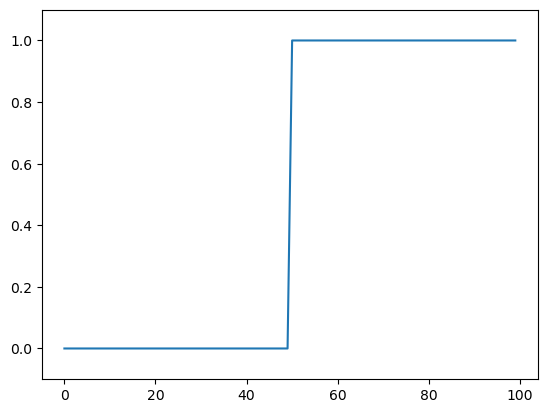

In [13]:
fig, ax = plt.subplots();
ax.plot(step_signal);
ax.margins(y=0.1);

**Exercise:** Can you predict what a convolution with the kernel `[-1, 0, 1]` does? Try thinking about it before running the cells below.

In [14]:
result_corr = np.correlate(step_signal, np.array([-1, 0, 1]), mode='valid');

In [15]:
result_conv = np.convolve (step_signal, np.array([-1, 0, 1]), mode='valid');

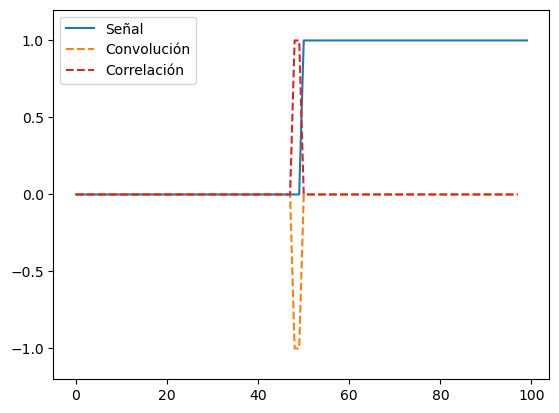

In [16]:
fig, ax = plt.subplots();
ax.plot(step_signal, label='Señal');
ax.plot(result_conv, linestyle='dashed', label='Convolución');
ax.plot(result_corr, linestyle='dashed', label='Correlación', color='C3');
ax.legend(loc='upper left');
ax.margins(y=0.1);

Por razones técnicas de procesamiento de señales, las convoluciones ocurren realmente "de atrás hacia adelante" entre la matriz de entrada y el núcleo. Las correlaciones ocurren en el orden de la señal.

Siempre que los valores vecinos están cerca, la respuesta del filtro se acerca a 0. Justo en el límite de un paso, estamos restando un valor pequeño de un valor grande y y obtenemos un pico en la respuesta. Este pico "identifica" nuestro borde.

## Filtrado local de imágenes

Ahora apliquemos todos estos conocimientos a imágenes 2D en lugar de a una señal 1D. Empecemos con una imagen increíblemente simple:

In [14]:
import numpy as np;

bright_square = np.zeros((7, 7), dtype=float);
bright_square[2:5, 2:5] = 1;

print(bright_square);

[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 1. 0. 0.]
 [0. 0. 1. 1. 1. 0. 0.]
 [0. 0. 1. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]


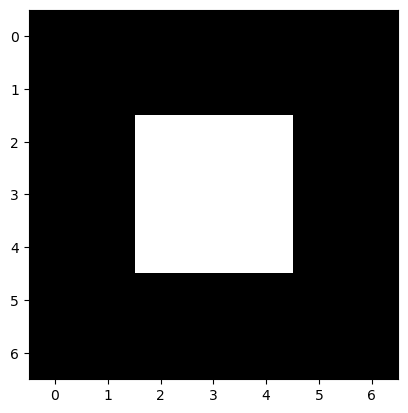

In [15]:
fig, ax = plt.subplots()
ax.imshow(bright_square);

### El filtro de medias

Para nuestro primer ejemplo de filtro, consideremos la siguiente matriz de filtrado, que llamaremos *kernel de medias*. Para cada píxel, un kernel define qué píxeles vecinos hay que tener en cuenta a la hora de filtrar, y cuánto hay que ponderar esos píxeles.

In [16]:
mean_kernel = np.full((3, 3), 1/9);

print(mean_kernel);

[[0.11111111 0.11111111 0.11111111]
 [0.11111111 0.11111111 0.11111111]
 [0.11111111 0.11111111 0.11111111]]


Ahora, tomemos nuestro núcleo de medias y apliquémoslo a cada píxel de la imagen.

Aplicar un filtro (lineal) significa esencialmente:
* Centrar un kernel en un píxel.
* Multiplicar los píxeles *bajo* ese kernel por los valores *dentro* del kernel
* Sumar todos los resultados
* Reemplazar el píxel central por el resultado de la suma.

Este proceso se conoce como **CONVOLUCIÓN**.

In [17]:
import scipy.ndimage as ndi;

%precision 2
print(bright_square);
print();
print(ndi.correlate(bright_square, mean_kernel));

[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 1. 0. 0.]
 [0. 0. 1. 1. 1. 0. 0.]
 [0. 0. 1. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]

[[0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.11 0.22 0.33 0.22 0.11 0.  ]
 [0.   0.22 0.44 0.67 0.44 0.22 0.  ]
 [0.   0.33 0.67 1.   0.67 0.33 0.  ]
 [0.   0.22 0.44 0.67 0.44 0.22 0.  ]
 [0.   0.11 0.22 0.33 0.22 0.11 0.  ]
 [0.   0.   0.   0.   0.   0.   0.  ]]


El significado de "kernel de medias" debería estar claro ahora: Cada píxel fue sustituido por el valor medio dentro de la vecindad de 3x3 de ese píxel. Cuando el kernel estaba sobre $n$ píxeles a 1, el píxel en el centro del kernel se cambiaba por $n/9$ ($=n*0,111$). Cuando no había píxeles brillantes bajo el núcleo, el resultado era 0.

Este filtro es un simple filtro de suavizado y produce dos resultados importantes:
1. La intensidad del píxel brillante disminuye.
2. La intensidad de la región cercana al píxel brillante aumenta.

In [18]:
from skimage import color;
from scipy import ndimage as ndi;
from matplotlib import patches;

def mean_filter_demo(image, vmax=1):
    mean_factor = 1.0 / 9.0;  # This assumes a 3x3 kernel.
    iter_kernel_and_subimage = iter_kernel(image);

    image_cache = [];

    def mean_filter_step(i_step):
        while i_step >= len(image_cache):
            filtered = image if i_step == 0 else image_cache[-1][-1][-1];
            filtered = filtered.copy();

            (i, j), mask, subimage = next(iter_kernel_and_subimage);
            filter_overlay = color.label2rgb(mask, image, bg_label=0, colors=('cyan', 'red'));
            filtered[i, j] = np.sum(mean_factor * subimage);
            image_cache.append(((i, j), (filter_overlay, filtered)));

        (i, j), images = image_cache[i_step];
        fig, axes = plt.subplots(1, len(images), figsize=(10, 5));
        
        for ax, imc in zip(axes, images):
            ax.imshow(imc, vmax=vmax);
            rect = patches.Rectangle([j - 0.5, i - 0.5], 1, 1, color='yellow', fill=False);
            ax.add_patch(rect);
            
        plt.show();
    return mean_filter_step;

def mean_filter_interactive_demo(image):
    from ipywidgets import IntSlider, interact;
    mean_filter_step = mean_filter_demo(image);
    step_slider = IntSlider(min=0, max=image.size-1, value=0);
    interact(mean_filter_step, i_step=step_slider);

def iter_kernel(image, size=1):
    width = 2*size + 1;
    for (i, j), pixel in iter_pixels(image):
        mask = np.zeros(image.shape, dtype='int16');
        mask[i, j] = 1;
        mask = ndi.grey_dilation(mask, size=width);
        #mask[i, j] = 2
        subimage = image[bounded_slice((i, j), image.shape[:2], size=size)];
        yield (i, j), mask, subimage;

def iter_pixels(image):
    height, width = image.shape[:2];
    for i in range(height):
        for j in range(width):
            yield (i, j), image[i, j];

def bounded_slice(center, xy_max, size=1, i_min=0):
    slices = [];
    for i, i_max in zip(center, xy_max):
        slices.append(slice(max(i - size, i_min), min(i + size + 1, i_max)));
    return tuple(slices);



In [19]:
mean_filter_interactive_demo(bright_square)

interactive(children=(IntSlider(value=0, description='i_step', max=48), Output()), _dom_classes=('widget-inter…

Por cierto, el filtrado anterior es exactamente el mismo principio en el que se basan las *redes neuronales convolucionales*, o CNN, que veremos más a delante. 

La única diferencia es que, mientras que en el caso anterior se utiliza el kernel medio simple, en las CNN, los valores dentro del kernel se *aprenden* para encontrar una característica específica, o realizar una tarea específica. 

### Imágenes de baja resolución

Consideremos ahora una imagen real. Será más fácil ver algunos de los filtros que estamos haciendo si reducimos un poco la muestra de la imagen. Podemos cortar la imagen usando el argumento "step" para submuestrearla.

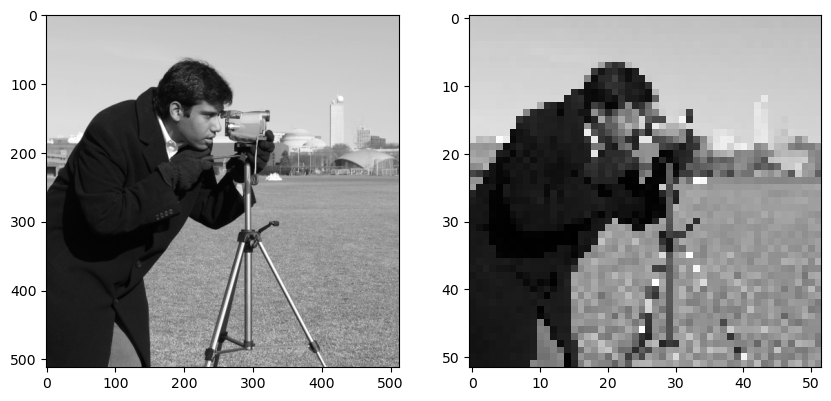

In [20]:
from skimage import data

image = data.camera()
pixelated = image[::10, ::10]

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5))
ax0.imshow(image)
ax1.imshow(pixelated) ;

Aquí utilizamos un step de 10, lo que nos da una de cada 10 columnas y filas de la imagen original.

En realidad, vamos a utilizar el patrón de trazar múltiples imágenes una al lado de la otra con bastante frecuencia, por lo que vamos a hacer la siguiente función de ayuda:

In [21]:
from skimage import img_as_float;

def imshow_all(*images, titles=None):
    images = [img_as_float(img) for img in images];

    if titles is None:
        titles = [''] * len(images);
    vmin = min(map(np.min, images));
    vmax = max(map(np.max, images));
    ncols = len(images);
    height = 5;
    width = height * len(images);
    fig, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(width, height));
    for ax, img, label in zip(axes.ravel(), images, titles):
        ax.imshow(img, vmin=vmin, vmax=vmax);
        ax.set_title(label);


### Filtro de medias de una imagen real

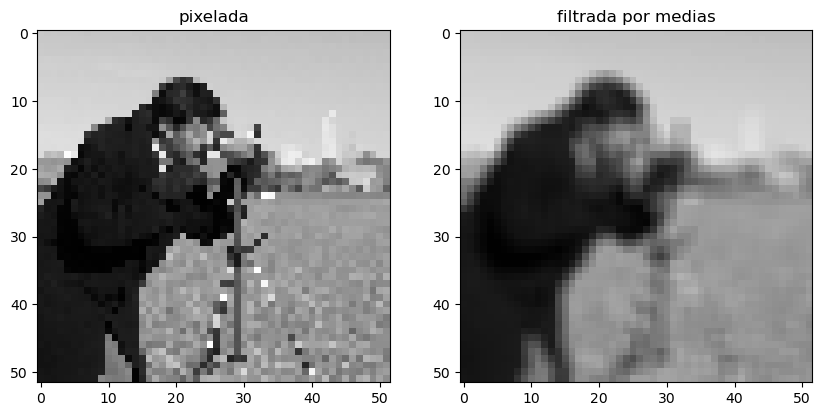

In [22]:
filtered = ndi.correlate(pixelated, mean_kernel)
imshow_all(pixelated, filtered, titles=['pixelada', 'filtrada por medias'])

Comparando la imagen filtrada con la imagen pixelada, podemos ver que este resultado filtrado es más suave: Los bordes afilados (que no son más que bordes entre píxeles oscuros y brillantes) se suavizan porque los píxeles oscuros reducen la intensidad de los píxeles vecinos y los píxeles brillantes hacen lo contrario.

## Filtros esenciales

Si has leído la última sección, ya estás familiarizado con los conceptos esenciales del filtrado de imágenes.

Pero, por supuesto, no tiene que crear kernels de filtrado personalizados para todas tus necesidades.

Hay muchos kernels de filtrado estándar predefinidos desde hace medio siglo de procesamiento de imágenes y señales.

### Filtro Gaussiano 

El filtro de imagen clásico es el filtro gaussiano. Es similar al filtro de media, ya que tiende a suavizar las imágenes. Sin embargo, el filtro gaussiano no pondera todos los valores de la vecindad por igual. En cambio, los píxeles más cercanos al centro se ponderan más que los más alejados.

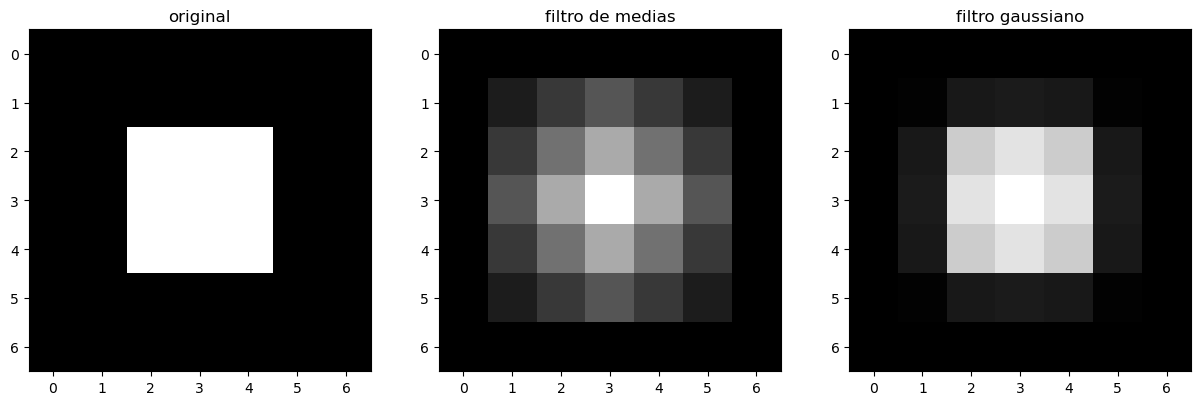

In [23]:
from skimage import filters

smooth_mean = ndi.correlate(bright_square, mean_kernel)
sigma = 0.5
smooth = filters.gaussian(bright_square, sigma)
imshow_all(bright_square, smooth_mean, smooth, titles=['original', 'filtro de medias', 'filtro gaussiano'])

Para el filtro gaussiano, $sigma$, la desviación estándar, define el tamaño de la vecindad.

Para una imagen real, obtenemos lo siguiente:

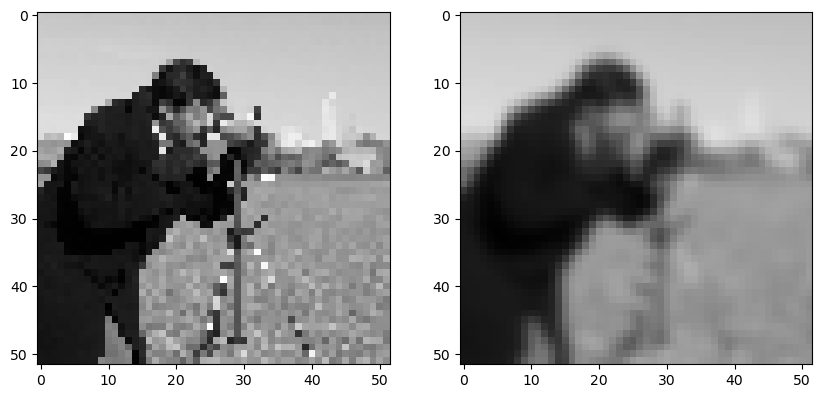

In [24]:
from skimage import img_as_float;

pixelated_float = img_as_float(pixelated);
smooth = filters.gaussian(pixelated_float, sigma=1);
imshow_all(pixelated_float, smooth);

Esto no parece drásticamente diferente del filtro de medias, pero el filtro gaussiano es típicamente preferido debido a la ponderación dependiente de la distancia, y porque no tiene transiciones bruscas.

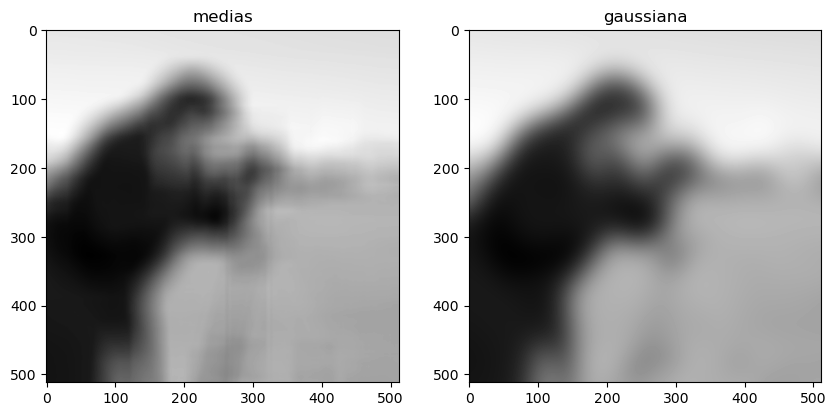

In [25]:
size = 20
structuring_element = np.ones((3*size, 3*size))
smooth_mean = filters.rank.mean(image, structuring_element)
smooth_gaussian = filters.gaussian(image, size)
titles = ['medias', 'gaussiana']
imshow_all(smooth_mean, smooth_gaussian, titles=titles)

Arriba, he ajustado el tamaño del elemento de estructuración utilizado para el filtro medio y la desviación estándar del filtro gaussiano para producir una cantidad aproximadamente igual de suavizado en los dos resultados.

Por cierto, como referencia, echemos un vistazo a lo que el filtro gaussiano realmente es. Técnicamente, el valor del kernel en un píxel que está a $r$ filas y $c$ cols del centro es:

$$
k_{r, c} = \frac{1}{2\pi \sigma^2} \exp{\left(-\frac{r^2 + c^2}{2\sigma^2}\right)}
$$

En la práctica, este valor es bastante cercano a cero para los valores más de $4\sigma$ lejos del centro, por lo que los filtros gaussianos prácticos se truncan en alrededor de $4\sigma$:


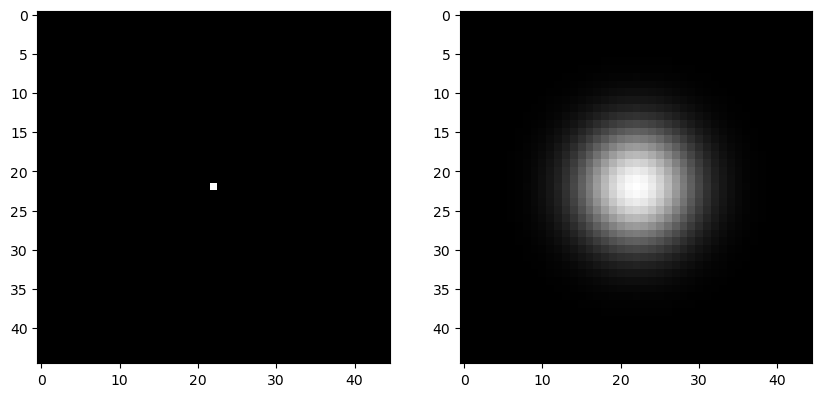

In [26]:
sidelen = 45;
sigma = (sidelen - 1) // 2 // 4;
spot = np.zeros((sidelen, sidelen), dtype=float);
spot[sidelen // 2, sidelen // 2] = 1;
kernel = filters.gaussian(spot, sigma=sigma);

imshow_all(spot, kernel / np.max(kernel));

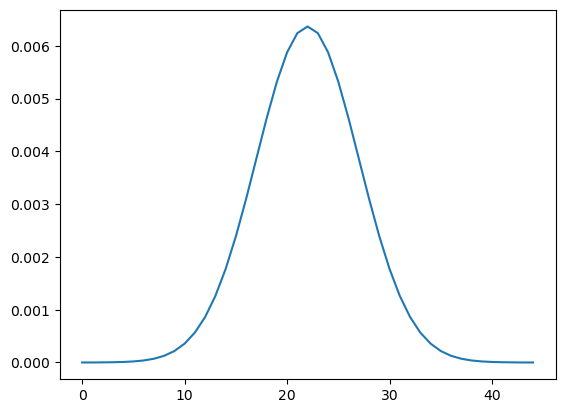

In [27]:
profile = kernel[:, kernel.shape[1] // 2];
plt.plot(profile);

### Filtrado básico de bordes

En el caso de las imágenes, los bordes son los límites entre los valores claros y oscuros. La detección de bordes puede ser útil por sí sola, o puede utilizarse como paso previo en otros algoritmos.

#### Filtros diferenciales en 2D

En el caso de las imágenes, se puede pensar en un borde como los puntos en los que el gradiente es grande en una dirección. Podemos aproximar los gradientes con filtros diferenciales.

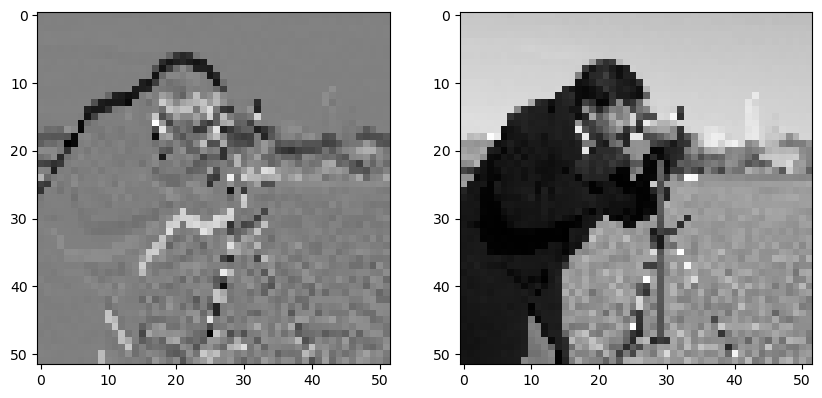

In [28]:
vertical_kernel = np.array([ [-1], [ 0], [ 1], ])

gradient_vertical = ndi.correlate(pixelated.astype(float), vertical_kernel)

fig, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].imshow(gradient_vertical)
ax[1].imshow(pixelated);

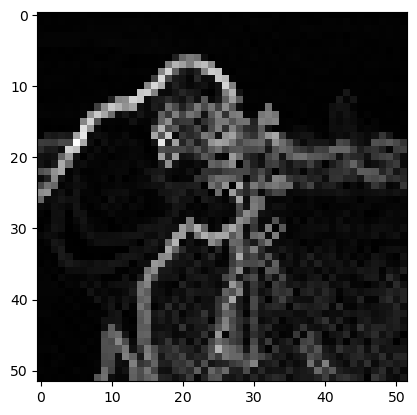

In [29]:
horizontal_kernel = vertical_kernel.T

gradient_horizontal = ndi.correlate(pixelated.astype(float), horizontal_kernel, mode='reflect')

gradient_mag = np.sqrt(gradient_vertical**2 + gradient_horizontal**2)

plt.imshow(gradient_mag)

### Filtro de bordes Sobel

El filtro Sobel, el filtro de bordes más utilizado, debería ser bastante similar a lo que hemos creado anteriormente. 


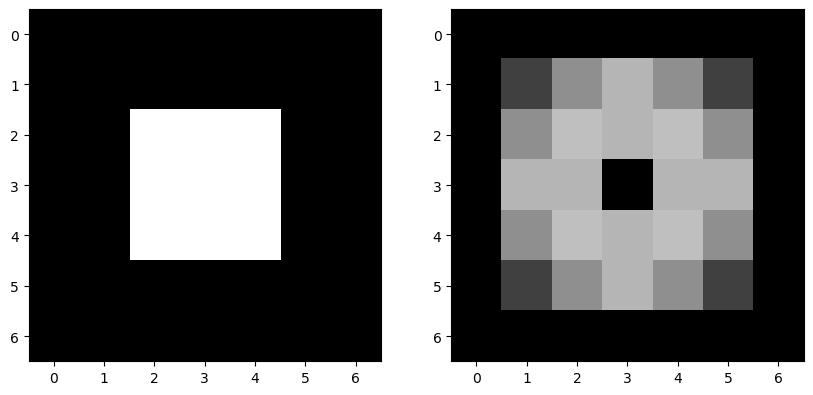

In [30]:
imshow_all(bright_square, filters.sobel(bright_square));

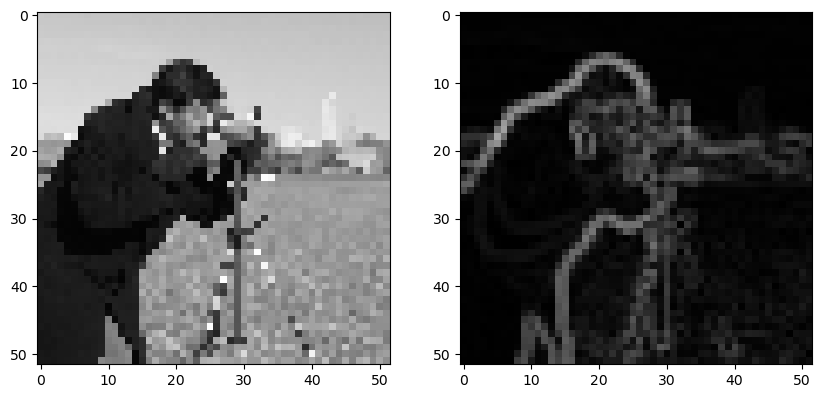

In [31]:
pixelated_gradient = filters.sobel(pixelated);
imshow_all(pixelated, pixelated_gradient);

El suavizado se utiliza a menudo como paso previo al procesamiento para la detección de características y las operaciones de mejora de la imagen, ya que los rasgos afilados pueden distorsionar los resultados.

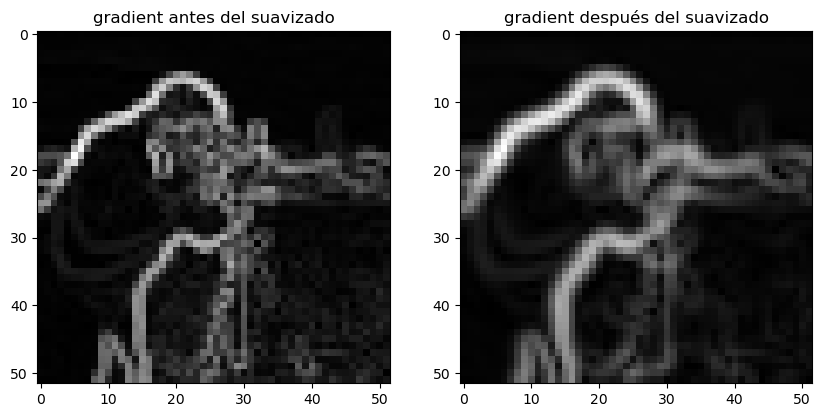

In [32]:
gradient = filters.sobel(smooth);
titles = ['gradient antes del suavizado', 'gradient después del suavizado'];
imshow_all(pixelated_gradient, gradient*1.8, titles=titles);

## Filtros de eliminación de ruido

Como se puede ver en nuestros ejemplos anteriores, los filtros de media y gaussianos suavizan una imagen de manera bastante uniforme, incluyendo los bordes de los objetos en una imagen. Sin embargo, cuando se realiza la eliminación de ruido, normalmente se desea preservar las características y sólo eliminar el ruido. La distinción entre ruido y características puede, por supuesto, depender en gran medida de la situación y ser subjetiva.

### Filtro de medianas

El filtro de medianas es el clásico filtro que preserva los bordes. Como su nombre indica, este filtro toma un conjunto de píxeles (es decir, los píxeles dentro de un núcleo o "elemento estructurador") y devuelve el valor de la mediana dentro de ese vecindario. Dado que las regiones cercanas a un borde pronunciado tendrán muchos valores oscuros y muchos valores claros (pero pocos valores intermedios), la mediana en un borde será probablemente clara u oscura, en lugar de algún valor intermedio. De este modo, no acabamos con bordes suavizados.

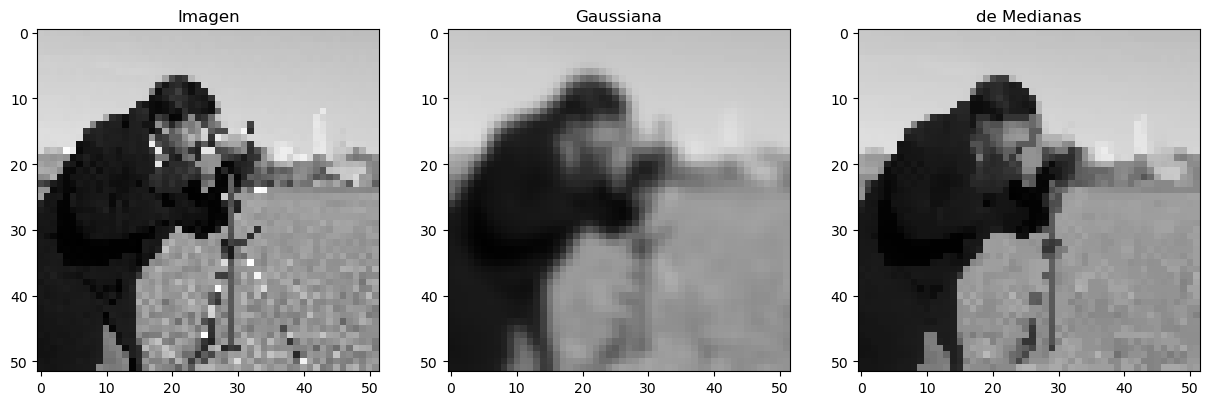

In [33]:
from skimage.morphology import disk;

neighborhood = disk(1);

median = filters.rank.median(pixelated, neighborhood);

titles = ['Imagen', 'Gaussiana', 'de Medianas'];

imshow_all(pixelated, smooth, median, titles=titles)

Esta diferencia es más notable con una imagen más detallada.

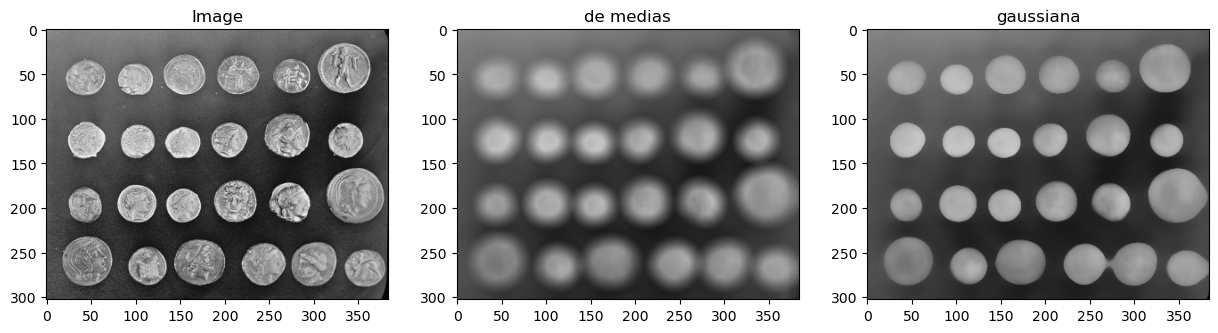

In [35]:
neighborhood = disk(10);
coins = data.coins();
mean_coin = filters.rank.mean(coins, neighborhood);
median_coin = filters.rank.median(coins, neighborhood);
titles = ['Image', 'de medias', 'gaussiana'];
imshow_all(coins, mean_coin, median_coin, titles=titles);

Observar cómo se conservan los bordes de las monedas después de utilizar el filtro de medianas.

*scikit-image* también proporciona filtros de eliminación de ruido más sofisticados:

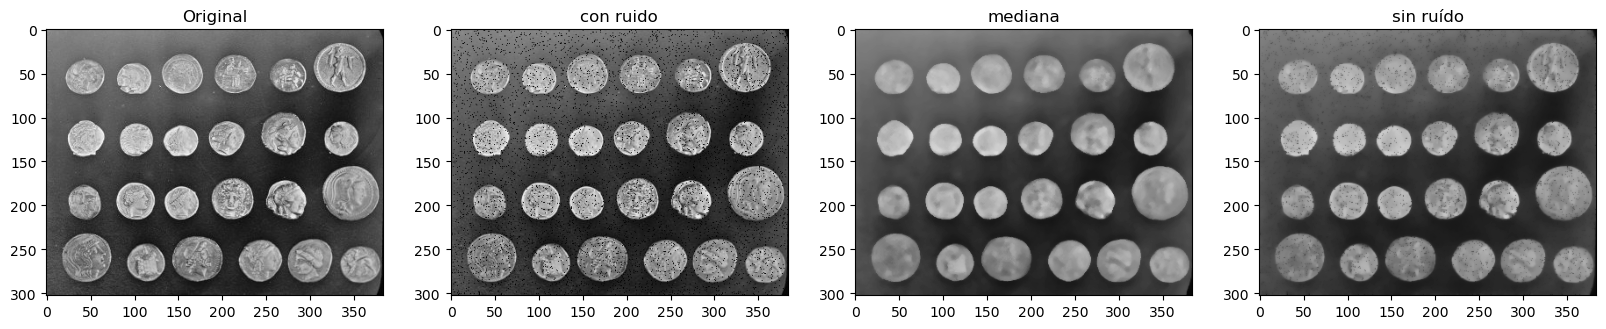

In [36]:
from skimage.restoration import denoise_tv_bregman;
from skimage.util        import random_noise;
from skimage.util        import img_as_ubyte;
from skimage.color       import rgb2gray;

image = data.coins();

img = random_noise(image, mode='salt',   seed=42, clip=True)
img = random_noise(img,   mode='pepper', seed=42, clip=True)

img = img_as_ubyte(img);

denoised = denoise_tv_bregman(img, 4);
median = filters.rank.median(img, disk(4));
titles = ['Original', 'con ruido', 'mediana', 'sin ruído'];
imshow_all(image, img, median, denoised, titles=titles);

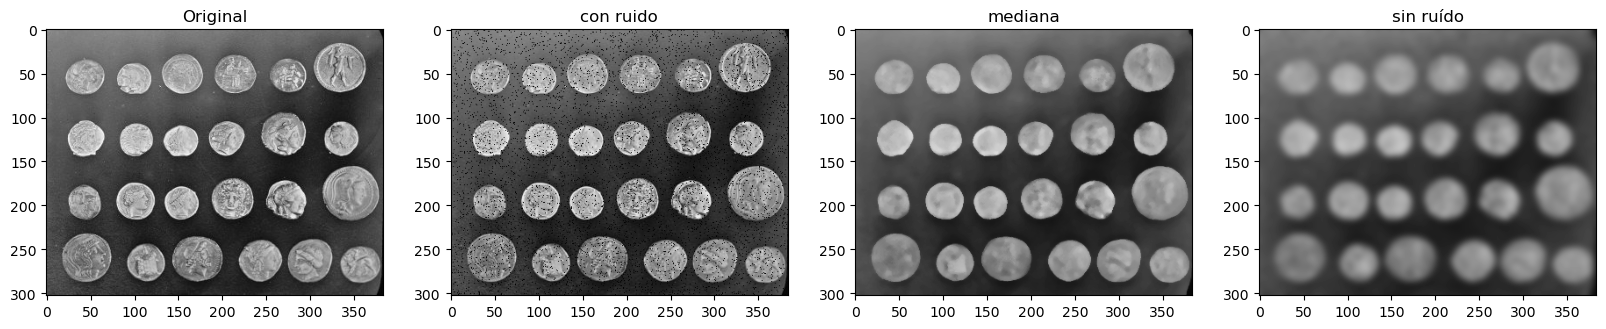

In [37]:
smooth = filters.gaussian(img, 4)
median = filters.rank.median(img, disk(4));
titles = ['Original', 'con ruido', 'mediana', 'sin ruído'];
imshow_all(image, img, median, smooth, titles=titles);

# Te toca

Busca en skimage, otros algoritmos que mejoren - si es posible - el ruído de esta imagen:

(usa esta documentación: https://scikit-image.org/docs/stable/api/skimage.restoration.html)

Ellipsis

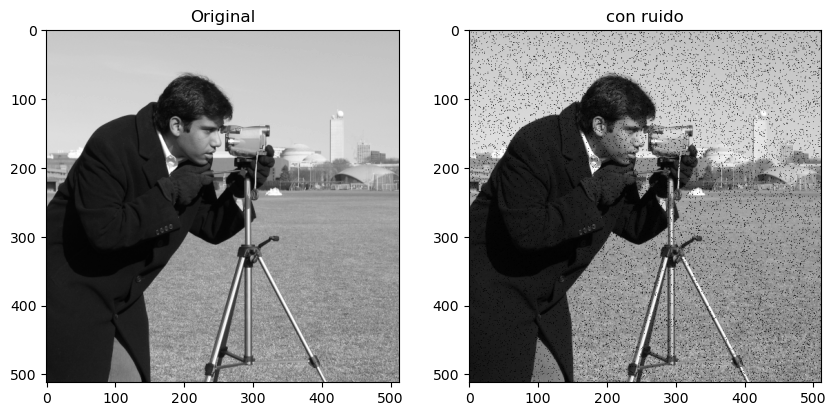

In [38]:
image = data.camera();

img = random_noise(image, mode='salt',   seed=42, clip=True)
img = random_noise(img,   mode='pepper', seed=42, clip=True)

img = img_as_ubyte(img);

denoised = denoise_tv_bregman(img, 4);
median = filters.rank.median(img, disk(4));
titles = ['Original', 'con ruido'];
imshow_all(image, img, titles=titles);

...

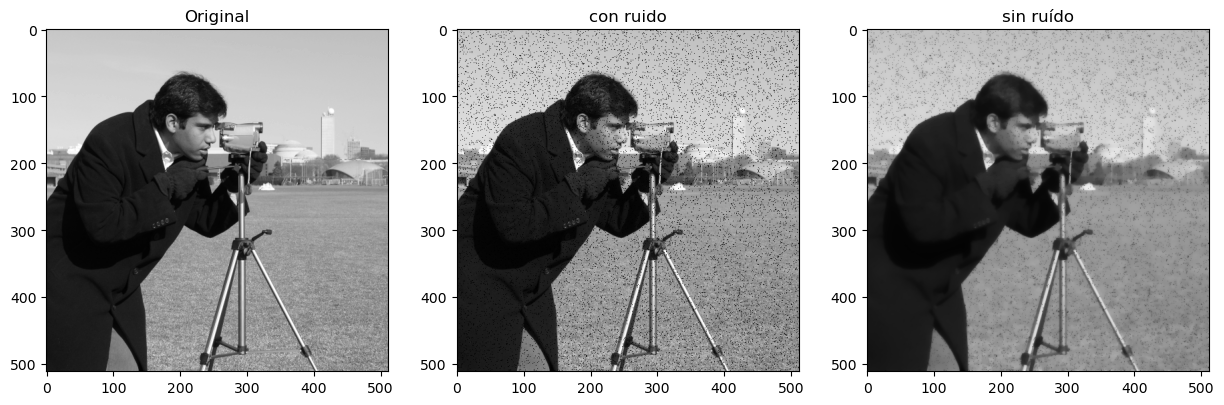

In [41]:
from skimage.restoration import denoise_tv_bregman;
from skimage.util        import random_noise;
from skimage.util        import img_as_ubyte;
from skimage.color       import rgb2gray;

image = data.camera();

img = random_noise(image, mode='salt',   seed=42, clip=True)
img = random_noise(img,   mode='pepper', seed=42, clip=True)

img = img_as_ubyte(img);

denoised = denoise_tv_bregman(img, 4);
# median = filters.rank.median(img, disk(4));
titles = ['Original', 'con ruido',  'sin ruído'];
imshow_all(image, img, denoised, titles=titles);

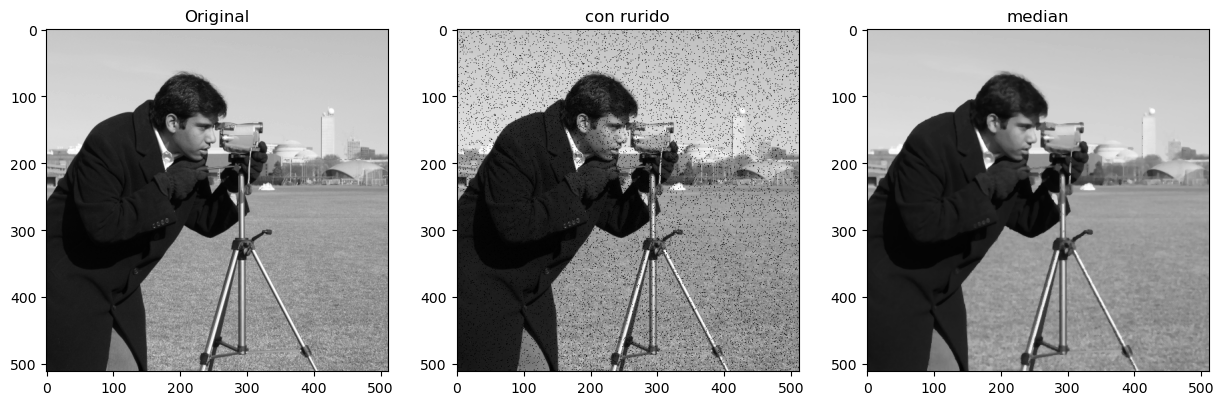

In [58]:
neighborhood = disk(10);
image = data.camera();

#Aplicamos ruido a la imagen
img = random_noise(image, mode='salt',   seed=42, clip=True)
img = random_noise(img,   mode='pepper', seed=42, clip=True)

img = img_as_ubyte(img);



#Aplicamos la mediana
median = filters.rank.median(img, disk(2));

titles = ['Original', 'con rurido', 'median'];
imshow_all(image, img, median,  titles=titles);